In [2]:
# %pip install ib_insync

  Using cached ib_insync-0.9.70-py3-none-any.whl (70 kB)
  Using cached eventkit-0.8.9-py3-none-any.whl (31 kB)
Note: you may need to restart the kernel to use updated packages.


In [42]:
# %pip install nest_asyncio
# %pip install pandas_ta
# %pip install arch

In [66]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas_ta as ta
from arch import arch_model

In [66]:
# df.ta.indicators()

In [37]:
from ib_insync import *
util.startLoop()

# import nest_asyncio
# nest_asyncio.apply()


ib = IB()
# ib.disconnect()
ib.connect('127.0.0.1', 7497, clientId=1)


contract = Crypto('BTC', exchange='PAXOS', currency='USD')
bars = ib.reqHistoricalData(
    contract, endDateTime='', durationStr='180 D',
    barSizeSetting='1 day', whatToShow='MIDPOINT', useRTH=True)

# convert to pandas dataframe:
df = util.df(bars)
df['returns'] = df['close'].pct_change()
df.head()


,date,open,high,low,close,volume,average,barCount,returns
0,2021-12-15,47801.625,49510.375,46581.375,49235.625,-1.0,-1.0,-1,NaN
1,2021-12-16,49332.625,49433.875,47670.125,47936.375,-1.0,-1.0,-1,-0.026388
2,2021-12-17,47965.875,48152.375,45479.375,46203.625,-1.0,-1.0,-1,-0.036147
3,2021-12-20,47550.875,48318.250,45572.375,47022.375,-1.0,-1.0,-1,0.017720
4,2021-12-21,47046.625,49334.000,46679.875,48637.625,-1.0,-1.0,-1,0.034351


-0.0038388248108566126

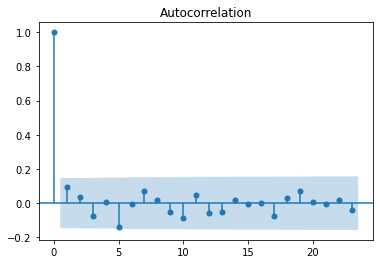

In [45]:
df.dropna(inplace=True)
plot_acf(df.returns)
len(df)
df.returns.mean()

In [43]:
from arch import arch_model

C:\Users\kushwaha\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\kushwaha\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\kushwaha\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\kushwaha\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kushwaha\Anaconda3\lib\site-packages\arch\u

Iteration:      1,   Func. Count:     14,   Neg. LLF: 408.40240273754137
Iteration:      2,   Func. Count:     31,   Neg. LLF: 87.45023105680498
Iteration:      3,   Func. Count:     47,   Neg. LLF: 80780.4730297127
Iteration:      4,   Func. Count:     62,   Neg. LLF: -233.9180311613623
Iteration:      5,   Func. Count:     76,   Neg. LLF: -234.88544856154704
Iteration:      6,   Func. Count:     90,   Neg. LLF: -235.19998458594745
Iteration:      7,   Func. Count:    104,   Neg. LLF: -235.4627613717342
Iteration:      8,   Func. Count:    117,   Neg. LLF: -235.47128043996625
Iteration:      9,   Func. Count:    130,   Neg. LLF: -235.4765921538659
Iteration:     10,   Func. Count:    143,   Neg. LLF: -235.47868544477808
Iteration:     11,   Func. Count:    156,   Neg. LLF: -235.47941552054863
Iteration:     12,   Func. Count:    169,   Neg. LLF: -235.48066978297345
Iteration:     13,   Func. Count:    182,   Neg. LLF: -235.4832272561248
Iteration:     14,   Func. Count:    195,   Neg.

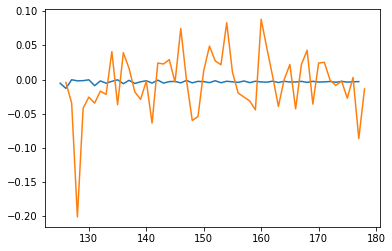

In [90]:
"""GARCH model"""
def ARCH(X):
    test_pct = 0.7
    train, test = X[0:int(test_pct*len(X))], X[int(test_pct*len(X)):len(X)-1]
    test_squared = [i**2 for i in test]
    
    model = arch_model(train, mean='Zero', vol='ARCH', p=5)
    model_fit = model.fit()
    y_hat = model_fit.forecast(horizon=int((1-test_pct)*len(X)))
#     display(y_hat.variance.values[-1,:])
    plt.plot(test_squared)
    plt.plot(y_hat.variance.values[-1,:], color='red')
    plt.show()    

def GARCH(X):
    test_pct = 0.7
    train, test = X[0:int(test_pct*len(X))], X[int(test_pct*len(X)):len(X)-1]
    test_squared = [i**2 for i in test]
    
    model = arch_model(train, mean='Zero', vol='GARCH', p=5, q=5)
    model_fit = model.fit()
    y_hat = model_fit.forecast(horizon=int((1-test_pct)*len(X)))    
    plt.plot(test_squared)
    plt.plot(y_hat.variance.values[-1,:], color='red')
    plt.show()    

def ARIMA_GARCH(X):
    pass
    
    

# GARCH(df.returns)
# X = df.returns
# test_pct = 0.7
# train, test = X[0:int(test_pct*len(X))], X[int(test_pct*len(X)):len(X)-1]
# test_squared = [i**2 for i in test]
# test_squared

# def ARIMA():
#     pass

X = df.returns
test_pct = 0.7
train, test = X[0:int(test_pct*len(X))], X[int(test_pct*len(X)):len(X)-1]
# test_squared = [i**2 for i in test]
# test_squared


model = ARIMA(train, order=(5,0,5))
model_fit = model.fit()
residuals = model_fit.resid

garch = arch_model(residuals, p=5, q=5)
garch_fitted = garch.fit()

predicted_mu = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
predicted_garch = garch_fitted.forecast(horizon=int((1-test_pct)*len(X)))
predicted_et = predicted_garch.mean['h.01'].iloc[-1]
# display(predicted_garch)
prediction = predicted_mu + predicted_et
# display(prediction)
plt.plot(prediction)
plt.plot(test)
plt.show()

# predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# for i in range(len(predictions)):
#     print('predicted:{}, forecast:{}'.format(predictions.iloc[i], test.iloc[i]))
# rmse = sqrt(mean_squared_error(test, predictions))
# print('test rmse: {}'.format(rmse))

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show

-9.39394309586252e-05

In [35]:
"""real time updates"""
# ib = IB()
# ib.connect('127.0.0.1', 7497, clientId=1)

from collections import deque
import pandas as pd

# short_ma=3
# long_ma=5

contract = Crypto('BTC', exchange='PAXOS', currency='USD')
# d_short = deque(maxlen=short_ma)
# d_long = deque(maxlen=long_ma)

df = pd.DataFrame(columns=['Time','Close'])

def onBarUpdate(bars, newBar):
    """builds dataframe """

    df.loc[len(df.index)]=[bars[-1].time, bars[-1].close]
    
    print(bars[-1])
    
    """instead of displaying, should send to appropriate fn to check criteria for trades"""
    """could use rolling windows in df to capture moving averages"""
    display(df)
    
    
    
bars = ib.reqRealTimeBars(contract=contract,
                          barSize=5,
                          whatToShow='MIDPOINT',
                         useRTH=False)
bars.updateEvent += onBarUpdate
# d2 = deque(maxlen=3)
# d2.append(onBarUpdate)
# display(bars)

ib.sleep(10)
ib.cancelRealTimeBars(bars)

RealTimeBar(time=datetime.datetime(2022, 8, 12, 3, 14, tzinfo=datetime.timezone.utc), endTime=-1, open_=23982.125, high=23982.125, low=23982.125, close=23982.125, volume=-1.0, wap=-1.0, count=-1)


,Time,Close
0,2022-08-12 03:14:00+00:00,23982.125


RealTimeBar(time=datetime.datetime(2022, 8, 12, 3, 14, 5, tzinfo=datetime.timezone.utc), endTime=-1, open_=23982.125, high=23982.125, low=23982.125, close=23982.125, volume=-1.0, wap=-1.0, count=-1)


,Time,Close
0,2022-08-12 03:14:00+00:00,23982.125
1,2022-08-12 03:14:05+00:00,23982.125


RealTimeBar(time=datetime.datetime(2022, 8, 12, 3, 14, 10, tzinfo=datetime.timezone.utc), endTime=-1, open_=23982.125, high=23982.125, low=23982.125, close=23982.125, volume=-1.0, wap=-1.0, count=-1)


,Time,Close
0,2022-08-12 03:14:00+00:00,23982.125
1,2022-08-12 03:14:05+00:00,23982.125
2,2022-08-12 03:14:10+00:00,23982.125


Peer closed connection.


In [32]:
import pandas as pd
df = pd.DataFrame(columns=['Date','Close'])
df.loc[len(df.index)]=['xxx',45]
df
# d3 = deque([1,3,3])
# df = pd.DataFrame({'d':d3})
# df

,Date,Close
0,xxx,45


In [98]:





d = deque(maxlen=3)
# for i in range(10):
#     d.append(i)
#     print(d)
    
def onBarUpdate(bars, newBar):
    d.append(bars[-1])
    print(d)
#     print(bars[-1])
    

def RealtimeMA(bars, newBar, short_MA, long_MA):
    short_deque = deque(maxlen=short_MA)
    long_deque = deque(maxlen=long_MA)
    
    short_deque.append
    
def GetRealTimeBars(contract, whatToShow='MIDPOINT'):
    bars = ib.reqRealTimeBars(contract=contract,
                              barSize=5,
                              whatToShow=whatToShow,
                              useRTH=False)
    bars.updateEvent += onBarUpdate
    ib.sleep(30)
    ib.cancelRealTimeBars(bars)

ib = IB()
# ib.disconnect()
ib.connect('127.0.0.1', 7497, clientId=1)


contract = Crypto('BTC', exchange='PAXOS', currency='USD')
GetRealTimeBars(contract)

    
    
    
    


deque([RealTimeBar(time=datetime.datetime(2022, 8, 12, 2, 46, 35, tzinfo=datetime.timezone.utc), endTime=-1, open_=23968.875, high=23968.875, low=23968.875, close=23968.875, volume=-1.0, wap=-1.0, count=-1)], maxlen=3)
deque([RealTimeBar(time=datetime.datetime(2022, 8, 12, 2, 46, 35, tzinfo=datetime.timezone.utc), endTime=-1, open_=23968.875, high=23968.875, low=23968.875, close=23968.875, volume=-1.0, wap=-1.0, count=-1), RealTimeBar(time=datetime.datetime(2022, 8, 12, 2, 46, 40, tzinfo=datetime.timezone.utc), endTime=-1, open_=23968.875, high=23968.875, low=23968.875, close=23968.875, volume=-1.0, wap=-1.0, count=-1)], maxlen=3)
deque([RealTimeBar(time=datetime.datetime(2022, 8, 12, 2, 46, 35, tzinfo=datetime.timezone.utc), endTime=-1, open_=23968.875, high=23968.875, low=23968.875, close=23968.875, volume=-1.0, wap=-1.0, count=-1), RealTimeBar(time=datetime.datetime(2022, 8, 12, 2, 46, 40, tzinfo=datetime.timezone.utc), endTime=-1, open_=23968.875, high=23968.875, low=23968.875, clo

In [100]:
ib.cancelRealTimeBars(bars)

Error 300, reqId 3: Can't find EId with tickerId:3


deque([RealTimeBar(time=datetime.datetime(2022, 8, 12, 2, 47, 35, tzinfo=datetime.timezone.utc), endTime=-1, open_=23971.375, high=23982.625, low=23971.375, close=23982.625, volume=-1.0, wap=-1.0, count=-1), RealTimeBar(time=datetime.datetime(2022, 8, 12, 2, 47, 40, tzinfo=datetime.timezone.utc), endTime=-1, open_=23982.625, high=23982.625, low=23982.625, close=23982.625, volume=-1.0, wap=-1.0, count=-1), RealTimeBar(time=datetime.datetime(2022, 8, 12, 2, 47, 45, tzinfo=datetime.timezone.utc), endTime=-1, open_=23982.625, high=23982.625, low=23982.625, close=23982.625, volume=-1.0, wap=-1.0, count=-1)], maxlen=3)
deque([RealTimeBar(time=datetime.datetime(2022, 8, 12, 2, 47, 40, tzinfo=datetime.timezone.utc), endTime=-1, open_=23982.625, high=23982.625, low=23982.625, close=23982.625, volume=-1.0, wap=-1.0, count=-1), RealTimeBar(time=datetime.datetime(2022, 8, 12, 2, 47, 45, tzinfo=datetime.timezone.utc), endTime=-1, open_=23982.625, high=23982.625, low=23982.625, close=23982.625, volu

In [43]:
# df_returns = df['returns']
# df.head()

df_adx = ta.adx(high=df['high'], low=df['low'], close=df['close'])
df_adx['date'] = df['date']
# rgs:
#         high (pd.Series): Series of 'high's
#         low (pd.Series): Series of 'low's
#         close (pd.Series): Series of 'close's
#         length (int): It's period. Default: 14
#         lensig (int): Signal Length. Like TradingView's default ADX. Default: length
#         scalar (float): How much to magnify. Default: 100
#         mamode (str): See ```help(ta.ma)```. Default: 'rma'
#         drift (int): The difference period. Default: 1
#         offset (int): How many periods to offset the result. Default: 0

In [54]:
df_adx.head()
df_adx = ta.adx(high=df['high'], low=df['low'], close=df['close'])
df['ADX'] = df_adx['ADX_14']
df['DMN'] = df_adx['DMN_14']
df['DMP'] = df_adx['DMP_14']
df.tail()
df = df.dropna()
df['DM_diff'] = df['DMP'] > df['DMN']
df.head()

<ipython-input-54-51be97dab127>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DM_diff'] = df['DMP'] > df['DMN']


,date,open,high,low,close,volume,average,barCount,returns,ADX,DMN,DMP,DM_diff
27,2022-01-11,41723.875,43114.125,41292.125,42797.625,-1.0,-1.0,-1,0.025437,34.701646,29.369654,9.064895,False
28,2022-01-12,42792.625,44087.875,42492.125,43845.125,-1.0,-1.0,-1,0.024476,35.306702,27.816603,11.812329,False
29,2022-01-13,43863.625,44451.125,42351.125,42814.125,-1.0,-1.0,-1,-0.023515,35.371692,25.877303,12.194749,False
30,2022-01-14,42743.875,43434.625,41780.125,43141.875,-1.0,-1.0,-1,0.007655,35.753328,26.359538,11.513686,False
31,2022-01-17,43247.375,43485.750,41878.125,42117.625,-1.0,-1.0,-1,-0.023741,36.021536,24.904118,11.053557,False


In [57]:
# help(ta.adx)

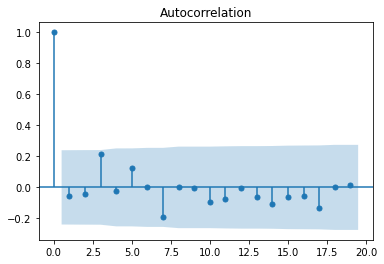

In [11]:
plot_acf(df_returns)
plt.show()

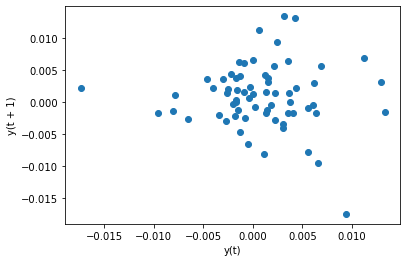

In [12]:
pd.plotting.lag_plot(df_returns)
plt.show()

In [23]:
l=len(df_returns)
p=0.7
# display(df_returns[0:int(p*l)], df_returns[int(p*l):l-1])


C:\Users\kushwaha\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


coefficients: [ 0.00045635 -0.13412065 -0.23278757  0.16762064  0.04256054  0.30334197]
predicted:-0.0007482044417033299, forecast:0.01299137641393222
predicted:0.0009115870396779917, forecast:0.0031061623101424907
predicted:0.0012795025144278773, forecast:0.013341380848662876
predicted:0.0004966451981069644, forecast:-0.001522708556689789
predicted:0.0015093253820092575, forecast:-0.0012967948418688424
predicted:0.00016461455260422103, forecast:0.004103192699433267
predicted:0.0004971487243727409, forecast:-0.001644915504104505
predicted:0.0010136124771255293, forecast:0.001813424522680851
predicted:0.0004471596435581345, forecast:-0.0004861524139535556
predicted:0.000708602694101597, forecast:-0.006509331939708485
predicted:0.0004982165530166671, forecast:-0.0026041259771982794
predicted:0.0004934763427811265, forecast:0.0013576810807141015
predicted:0.0007194672283371007, forecast:-0.0017521628259883348
predicted:0.0004942938259872747, forecast:1.0447846960026652e-05
predicted:0.000

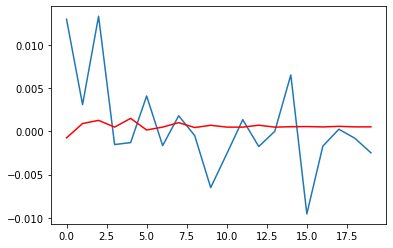

Peer closed connection.


In [26]:

def AutoRegModel(X, lags):
    test_pct = 0.7
    train, test = X[0:int(test_pct*len(X))], X[int(test_pct*len(X)):len(X)-1]
    
    model = AutoReg(train, lags=lags)
    model_fit = model.fit()
    print('coefficients: {}'.format(model_fit.params))
    
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
    
    for i in range(len(predictions)):
        print('predicted:{}, forecast:{}'.format(predictions[i], test[i]))
    rmse = sqrt(mean_squared_error(test, predictions))
    print('test rmse: {}'.format(rmse))
          
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show
          
                                             
AutoRegModel(df_returns.values, 5)    
    
    

In [52]:
def GetMovingAverages(df, low, high):
    df[str(low)+'_average'] = df.close.rolling(low).mean()
    df[str(high)+'_average'] = df.close.rolling(high).mean()
    df2 = df.dropna()
    df2['MA_diff'] = df[str(high)+'_average'] > df[str(low)+'_average']
    return df2
    
    

In [111]:
df_MA =  GetMovingAverages(df, 5, 10)

<ipython-input-52-7184740e6041>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['MA_diff'] = df[str(high)+'_average'] > df[str(low)+'_average']


<AxesSubplot:>

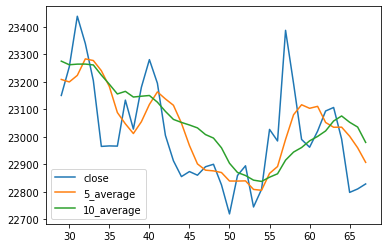

In [112]:
df_MA['close'].plot(legend=True)
df_MA['5_average'].plot(legend=True)
df_MA['10_average'].plot(legend=True)

In [102]:

def PlaceOrder(order_type, USD_balance, BTC_balance, price=None, quantity=None):
        
    if order_type=='sell':
        print('{} @ {}'.format(order_type, price))
        BTC_balance -= quantity
        USD_balance += quantity * price
    
    elif order_type=='buy':
        print('{} @ {}'.format(order_type, price))
        BTC_balance += quantity
        USD_balance -= quantity * price
    
    else:
        return USD_balance, BTC_balance   
 
        
    print('USD balance: {}'.format(USD_balance))
    print('BTC balance: {}'.format(BTC_balance))
    account_balance = USD_balance + BTC_balance * price
    print('Account balance: {}\n'.format(account_balance))
    
    
    return USD_balance, BTC_balance   
    
    
    
def GetSignals(df):
    USD_balance = 1000
    BTC_balance = 0
    
    for count, row in enumerate(df.iterrows()):
        if count==0:
            sentiment = row[1]['MA_diff']
        else:
            if row[1]['MA_diff'] == sentiment:
                USD_balance, BTC_balance = PlaceOrder('no change', USD_balance, BTC_balance)
            else:
                if row[1]['MA_diff']:
                    USD_balance, BTC_balance = PlaceOrder('sell', USD_balance, BTC_balance, row[1]['close'],1)
                else:
                    USD_balance, BTC_balance = PlaceOrder('buy', USD_balance, BTC_balance, row[1]['close'],1)
                sentiment = row[1]['MA_diff']
    print('USD balance: {}'.format(USD_balance))
    print('BTC balance: {}'.format(BTC_balance))
  
    account_value = USD_balance + BTC_balance * row[1]['close']
    print('Account value: {}'.format(account_value))
    

In [113]:
GetSignals(df_MA)
# df_MA

buy @ 23338.875
USD balance: -22338.875
BTC balance: 1
Account balance: 1000.0

sell @ 22966.625
USD balance: 627.75
BTC balance: 0
Account balance: 627.75

buy @ 23194.375
USD balance: -22566.625
BTC balance: 1
Account balance: 627.75

sell @ 22855.125
USD balance: 288.5
BTC balance: 0
Account balance: 288.5

buy @ 23026.625
USD balance: -22738.125
BTC balance: 1
Account balance: 288.5

sell @ 23106.375
USD balance: 368.25
BTC balance: 0
Account balance: 368.25

USD balance: 368.25
BTC balance: 0
Account value: 368.25


In [45]:
def Backtest():
    USD_balance = 1000
    BTC_balance = 0
    
    

In [63]:
from ib_insync import *
from collections import deque
util.startLoop()

contract_dict = {'Stock':Stock, 'Crypto':Crypto}

class Algo():
    def __init__(self, client, addr, port, client_id):
        self.client = client
        self.addr = addr
        self.port = port
        self.client_id = client_id
        
        self.client.connect(addr, port, client_id)
        
    def SetPaperBalances(self):
        self.USD_balance = 1000
        self.BTC_balance = 0
        
        print('USD balance: {}'.format(self.USD_balance))
        print('BTC balance: {}'.format(self.BTC_balance))
    
    def GetContract(self, contract_type, ticker, exchange, currency):
        return contract_dict[contract_type](ticker, exchange, currency)
    
    def GetHistoricalData(self, contract, duration='1 D', bar_size='1 hour'):
        bars = ib.reqHistoricalData(contract=contract, endDateTime='', durationStr=duration,
                                    barSizeSetting=bar_size, whatToShow='MIDPOINT', useRTH=True)
        return bars
    
    def BuildEMA(self, slow_period, fast_period):
        """using deques instead of dataframes"""
        self.slow_ema = deque(maxlen=slow_period)
        self.fast_ema = deque(maxlen=fast_period)
        
        """need to employ scanner to pull in data"""
        
           
    def GetDMI(self, df):
        df_adx = ta.adx(high=df['high'], low=df['low'], close=df['close'])
        df['ADX'] = df_adx['ADX_14']
        df['DMN'] = df_adx['DMN_14']
        df['DMP'] = df_adx['DMP_14']
        df['DM_diff'] = df['DMP'] > df['DMN']
        return df
        
    
    
    def GetMovingAverages(self, df, low, high, plot=True):
        df[str(low)+'_average'] = df.close.rolling(low).mean()
        df[str(high)+'_average'] = df.close.rolling(high).mean()
        df.dropna(inplace=True)
        df['MA_diff'] = df[str(high)+'_average'] > df[str(low)+'_average']
        
        if plot:
            df['close'].plot(legend=True)
            df[str(low)+'_average'].plot(legend=True)
            df[str(high)+'_average'].plot(legend=True)
        
        return df
    
    
    def PlacePaperOrder(self, order_type, price=None, quantity=None, date=None):

        if order_type=='sell':
            print(date)
            print('{} @ {}'.format(order_type, price))
            self.BTC_balance -= quantity
            self.USD_balance += quantity * price
            

        elif order_type=='buy':
            print(date)
            print('{} @ {}'.format(order_type, price))
            self.BTC_balance += quantity
            self.USD_balance -= quantity * price

        else:
            return 


        print('USD balance: {}'.format(self.USD_balance))
        print('BTC balance: {}'.format(self.BTC_balance))
        account_balance = self.USD_balance + self.BTC_balance * price
        print('Account balance: {}\n'.format(account_balance))       

    def RunDMI(self, df, ADX_MIN=20):
        for count, row in enumerate(df.iterrows()):
            if count==0:
                sentiment = row[1]['DM_diff']
            else:
                if (row[1]['ADX'] >= ADX_MIN):
                    if row[1]['DM_diff'] == sentiment:
                        self.PlacePaperOrder('no change')
                    else:
                        if row[1]['DM_diff']:
                            self.PlacePaperOrder('buy',row[1]['close'],1, row[1]['date'])
                        else:
                            self.PlacePaperOrder('sell', row[1]['close'],1, row[1]['date'])
                    sentiment = row[1]['DM_diff']
                else: continue                                     
                        
    
    def RunStrategy(self, df):   

        for count, row in enumerate(df.iterrows()):
            if count==0:
                sentiment = row[1]['MA_diff']
            else:
                if row[1]['MA_diff'] == sentiment:
                    self.PlacePaperOrder('no change')
                else:
                    if row[1]['MA_diff']:
                        self.PlacePaperOrder('sell',row[1]['close'],1)
                    else:
                        self.PlacePaperOrder('buy', row[1]['close'],1)
                    sentiment = row[1]['MA_diff']


def Main(client_id):
    """need to change so when crossover happens, closes current position and then goes in opposite direction """
    ib = IB()
    algo = Algo(ib, '127.0.0.1', 7497, client_id=client_id)
    
    contract = algo.GetContract('Crypto','BTC', 'PAXOS', 'USD')
#     contract = algo.GetContract('Stock','SPY', 'SMART', 'USD')
    
    bars = algo.GetHistoricalData(contract, '180 D', '1 day')
    
    df = util.df(bars)
    
    algo.SetPaperBalances()
    
#     df_MA =  algo.GetMovingAverages(df, 10, 30, True)
    df_DMI = algo.GetDMI(df)
    
#     algo.RunStrategy(df_MA)
    algo.RunDMI(df_DMI)
    
    print('USD balance: {}'.format(algo.USD_balance))
    print('BTC balance: {}'.format(algo.BTC_balance))

    account_value = algo.USD_balance + algo.BTC_balance * bars[-1].close
    print('Account value: {}'.format(account_value))
    
    

In [64]:
Main(5)

USD balance: 1000
BTC balance: 0
2022-02-07
buy @ 44175.75
USD balance: -43175.75
BTC balance: 1
Account balance: 1000.0

2022-02-18
sell @ 40031.125
USD balance: -3144.625
BTC balance: 0
Account balance: -3144.625

2022-03-01
buy @ 44117.375
USD balance: -47262.0
BTC balance: 1
Account balance: -3144.625

2022-05-09
sell @ 30948.0
USD balance: -16314.0
BTC balance: 0
Account balance: -16314.0

2022-07-19
buy @ 23408.625
USD balance: -39722.625
BTC balance: 1
Account balance: -16314.0

2022-07-25
sell @ 21891.125
USD balance: -17831.5
BTC balance: 0
Account balance: -17831.5

2022-07-28
buy @ 23798.25
USD balance: -41629.75
BTC balance: 1
Account balance: -17831.5

USD balance: -41629.75
BTC balance: 1
Account value: -17353.625


Peer closed connection.
Peer closed connection.
Peer closed connection.


In [14]:
from collections import deque

In [17]:
d = deque(maxlen=5)

In [19]:
d.append(1)

In [21]:
for i in range(10):
    d.append(i)
    print(d)

deque([1, 0], maxlen=5)
deque([1, 0, 1], maxlen=5)
deque([1, 0, 1, 2], maxlen=5)
deque([1, 0, 1, 2, 3], maxlen=5)
deque([0, 1, 2, 3, 4], maxlen=5)
deque([1, 2, 3, 4, 5], maxlen=5)
deque([2, 3, 4, 5, 6], maxlen=5)
deque([3, 4, 5, 6, 7], maxlen=5)
deque([4, 5, 6, 7, 8], maxlen=5)
deque([5, 6, 7, 8, 9], maxlen=5)
